In [1]:
import numpy as np
import pandas as pd
import torch
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns

np.random.seed(13)

pd.set_option('display.max_columns', None)

# DATA ACQUISITION

In [2]:
datasets_csv = ["movies.csv", "ratings.csv", "genome-scores.csv", "genome-tags.csv", "links.csv", "tags.csv"]
datasets_name = [i[:-4].replace("-", "_") for i in datasets_csv]

root_URL = "http://github.com/MickPerl/DataAnalyticsProject/releases/download/datasets/"
remote_url = ["".join([root_URL, i]) for i in datasets_csv]

In [3]:
try :
    if os.getcwd().split("/")[-1] != 'ml-25m':
        os.chdir('data/ml-25m/')
except FileNotFoundError :
    os.makedirs("data/ml-25m")
    os.chdir('data/ml-25m/')

In [4]:
# per vedere se i csv sono già presenti
!ls

# per assicurarsi di essere nel virtual environment
!which python

data
genome-scores.csv
genome-tags.csv
links.csv
movies.csv
ratings.csv
tags.csv
/c/Users/miche/Documents/GitHub/DataAnalyticsProject/venv/Scripts/python


In [5]:
for i in range(len(datasets_csv)):
    try :
        globals()["_".join(['df', datasets_name[i]])] = pd.read_csv(datasets_csv[i])
    except FileNotFoundError:
        print(f"Download in progress of {datasets_csv[i]}")
        file = urllib.request.urlretrieve(remote_url[i], datasets_csv[i])
        globals()["_".join(['df', datasets_name[i]])] = pd.read_csv(file[0])

# PRE PROCESSING

In [6]:
df_movies["year"] = [i.strip()[-5:-1] for i in df_movies["title"]]
df_movies["title_length"] = [len(i) for i in df_movies["title"]]
df_movies.drop("title", inplace=True, axis=1)

In [7]:
# SPIEGARE
mlb = MultiLabelBinarizer()
df_movies = df_movies.join(pd.DataFrame(
                mlb.fit_transform(df_movies.pop('genres').str.split('|')),
                index=df_movies.index,
                columns=mlb.classes_))

In [8]:
df_movies['genres'] = df_movies.iloc[:,3:23].values.tolist()
df_movies.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres
0,1,1995,16,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,2,1995,14,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,3,1995,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,1995,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,5,1995,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Hamming

In [9]:
np.sum(np.bitwise_xor([1,1,0,0,0],[1,0,1,1,0]))

3

In [10]:
df_genome = pd.merge(df_genome_tags, df_genome_scores, on="tagId")
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df = pd.merge(df_movies, df_genome, on="movieId", how = "left")

In [11]:
df_ratings = df_ratings.iloc[:,[1,2]]
df_ratings = df_ratings.groupby(by='movieId').mean()
df = pd.merge(df_ratings, df, on="movieId")

In [12]:
df_X = df.loc[:,df.columns != 'rating']
df_Y = df['rating']

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=20)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=20)

In [13]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.describe()

movieId        rating  title_length  (no genres listed)  \
count   59047.000000  59047.000000  59047.000000        59047.000000   
mean   120692.748065      3.071374     25.479991            0.077362   
std     64452.508194      0.739840     11.893284            0.267167   
min         1.000000      0.500000      2.000000            0.000000   
25%     78277.000000      2.687500     18.000000            0.000000   
50%    136782.000000      3.150000     23.000000            0.000000   
75%    173812.000000      3.500000     30.000000            0.000000   
max    209171.000000      5.000000    191.000000            1.000000   

             Action     Adventure     Animation      Children        Comedy  \
count  59047.000000  59047.000000  59047.000000  59047.000000  59047.000000   
mean       0.117076      0.065507      0.049300      0.048538      0.271834   
std        0.321514      0.247421      0.216495      0.214901      0.444909   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              Crime   Documentary         Drama       Fantasy     Film-Noir  \
count  59047.000000  59047.000000  59047.000000  59047.000000  59047.000000   
mean       0.085085      0.092350      0.414331      0.045167      0.005911   
std        0.279010      0.289522      0.492610      0.207673      0.076653   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             Horror          IMAX       Musical       Mystery       Romance  \
count  59047.000000  59047.000000  59047.000000  59047.000000  59047.000000   
mean       0.097312      0.003302      0.017224      0.047115      0.123715   
std        0.296385      0.057372      0.130105      0.211887      0.329259   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             Sci-Fi      Thriller           War       Western           007  \
count  59047.000000  59047.000000  59047.000000  59047.000000  13816.000000   
mean       0.059309      0.141074      0.029976      0.019578      0.046596   
std        0.236204      0.348101      0.170523      0.138545      0.071478   
min        0.000000      0.000000      0.000000      0.000000      0.007000   
25%        0.000000      0.000000      0.000000      0.000000      0.025750   
50%        0.000000      0.000000      0.000000      0.000000      0.033750   
75%        0.000000      0.000000      0.000000      0.000000      0.045312   
max        1.000000      1.000000      1.000000      1.000000      0.999750   

       007 (series)  18th century         1920s         1930s         1950s  \
count  13816.000000  13816.000000  13816.000000  13816.000000  13816.000000   
mean       0.044771      0.078292      0.085599      0.129250      0.088348   
std        0.062601      0.111595      0.086021      0.146648      0.105167   
min        0.007250      0.006000      0.010000      0.017250      0.004250   
25%        0.026750      0.028750      0.037250      0.053250      0.029500   
50%        0.034750      0.042000      0.0

Select rows with missing data

In [14]:
df.fillna(0)

In [ ]:
df.to_csv("")

In [ ]:
len(df[pd.isnull(df).any(axis=1)])


In [ ]:
len(df[pd.isnull(df).any(axis=1)])

In [ ]:
pd.isnull(df).sum()

## Checking duplicates 

In [16]:
any(df.astype(str).duplicated())

False

## Evaluating standardization

Si è valutata fattibilità della standardizzazione sulle relevance dei tags, ma non ha distribuzione gaussiana.

In [17]:
X_train_tags = X_train.iloc[:, 24:]
# X_train_tags_mean = X_train_tags.mean()
# X_train_tags_std = X_train_tags.std()
# X_train.iloc[:, 24:] = (X_train_tags - X_train_tags_mean) / X_train_tags_std
# X_val.iloc[:, 24:] = (X_val.iloc[:, 24:] - X_train_tags_mean) / X_train_tags_std
# X_train.iloc[:, 24:] = (X_test.iloc[:, 24:] - X_train_tags_mean) / X_train_tags_std

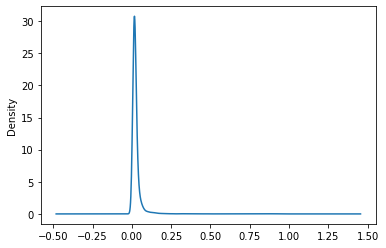

In [18]:
X_train_tags.loc[:, "american civil war"].plot(kind ='density')
plt.show()

In [19]:
pd.set_option('expand_frame_repr', False)
list(df.columns)

['movieId',
 'rating',
 'year',
 'title_length',
 '(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'genres',
 '007',
 '007 (series)',
 '18th century',
 '1920s',
 '1930s',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '19th century',
 '3d',
 '70mm',
 '80s',
 '9/11',
 'aardman',
 'aardman studios',
 'abortion',
 'absurd',
 'action',
 'action packed',
 'adaptation',
 'adapted from:book',
 'adapted from:comic',
 'adapted from:game',
 'addiction',
 'adolescence',
 'adoption',
 'adultery',
 'adventure',
 'affectionate',
 'afi 100',
 'afi 100 (laughs)',
 'afi 100 (movie quotes)',
 'africa',
 'afterlife',
 'aging',
 'aids',
 'airplane',
 'airport',
 'alaska',
 'alcatraz',
 'alcoholism',
 'alien',
 'alien invasion',
 'aliens',
 'allegory',
 'almodovar',
 'alone in the world',
 'alter ego',
 'alternate en

## Evaluating normalization

In [53]:
any(Y_train < 1)

False

## Evaluating labels' unbalance

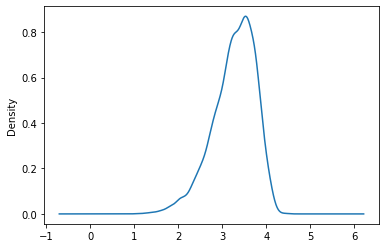

In [20]:
Y_train.plot(kind ='density')
plt.show()

In [54]:
len(Y_train)

9946

In [48]:
a = Y_train.loc[Y_train < 1.5]
b = Y_train.loc[Y_train >= 1.5 & Y_train < 2.5]
c = Y_train.loc[Y_train < 1.5]

cat = []

for i in range(0.5, 5,  0.5) :
    cat.append(Y_train.loc[(Y_train >= i) & Y_train < i+0.5])


12716    4.027100
1076     4.014332
3976     4.033846
5987     4.082880
12531    4.080328
1094     4.035884
1099     4.048278
12876    4.082083
6581     4.053627
12916    4.069954
13249    4.200000
2660     4.228311
7302     4.006849
7346     4.066310
12701    4.151786
1701     4.077006
10638    4.015198
1108     4.127091
2551     4.045397
3137     4.021732
2566     4.107340
11139    4.078100
3885     4.032448
106      4.002273
11882    4.074405
684      4.215804
775      4.324336
821      4.206564
1093     4.142050
12261    4.028889
1073     4.144122
12382    4.038306
10945    4.068675
2612     4.104965
986      4.092294
13178    4.111212
2783     4.053081
12678    4.122302
4758     4.126880
680      4.104362
12476    4.078947
7958     4.052304
7999     4.040541
13794    4.209677
856      4.022018
13156    4.005814
12444    4.056122
807      4.137713
1022     4.065127
12360    4.033416
3342     4.043699
662      4.103381
11681    4.097928
6313     4.010880
11972    4.105127
1177     4

## Checking correlation

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="species")

In [ ]:
# PRE DATA VISUALIZATION
df_Y.plot(kind ='density')
plt.show()

[] Normalizzazione (valtare se serve stampando distanze tra campioni)\
[] SVM regressione e custom kernel